In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [46]:
# Load and inspect dataset
# Step 1: Convert raw text file to DataFrame
raw_file_path = "C:/Users/User/Desktop/Hackathon/DATAVERSE/individual+household+electric+power+consumption/household_power_consumption.txt"
output_csv_path = "household_power_consumption.csv"

In [47]:

# Read raw text file
data = pd.read_csv(raw_file_path, sep=';', low_memory=False)

In [48]:
# Replace '?' with NaN and drop missing rows
data.replace('?', np.nan, inplace=True)
data.dropna(inplace=True)

In [49]:
# Convert to appropriate data types
data = data.astype({
    "Global_active_power": float,
    "Global_reactive_power": float,
    "Voltage": float,
    "Global_intensity": float,
    "Sub_metering_1": float,
    "Sub_metering_2": float,
    "Sub_metering_3": float
})

In [50]:
# Save to CSV for future use
data.to_csv(output_csv_path, index=False)
print(f"Data successfully saved to {output_csv_path}")


Data successfully saved to household_power_consumption.csv


In [51]:
# Step 2: Reload and parse the CSV
data = pd.read_csv(output_csv_path, parse_dates=[["Date", "Time"]], infer_datetime_format=True)
data.rename(columns={"Date_Time": "datetime"}, inplace=True)


C:\Users\User\AppData\Local\Temp\ipykernel_11184\2201974181.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(output_csv_path, parse_dates=[["Date", "Time"]], infer_datetime_format=True)
C:\Users\User\AppData\Local\Temp\ipykernel_11184\2201974181.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(output_csv_path, parse_dates=[["Date", "Time"]], infer_datetime_format=True)
C:\Users\User\AppData\Local\Temp\ipykernel_11184\2201974181.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data =

In [52]:
# Feature Engineering
data['hour'] = data['datetime'].dt.hour
data['day'] = data['datetime'].dt.day
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year

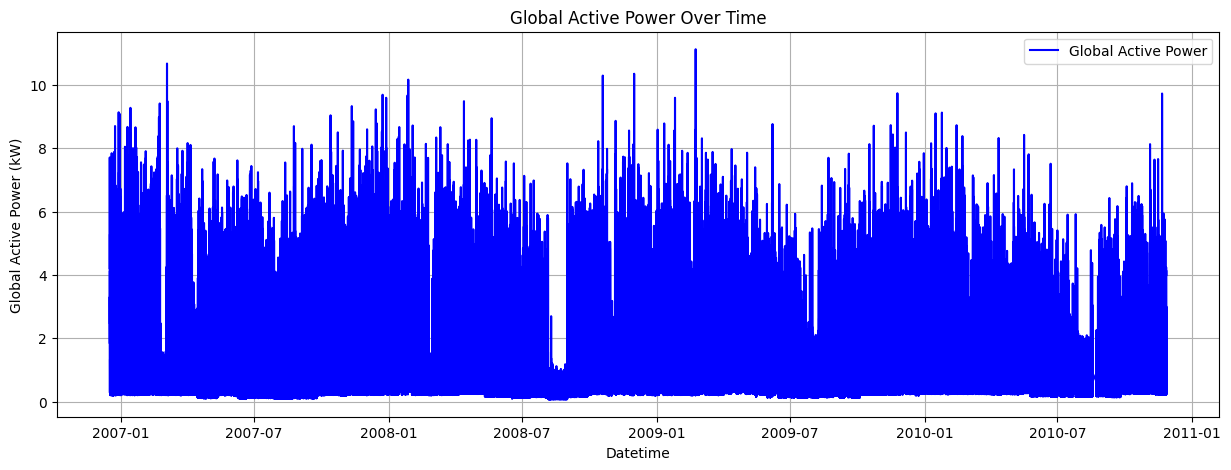

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


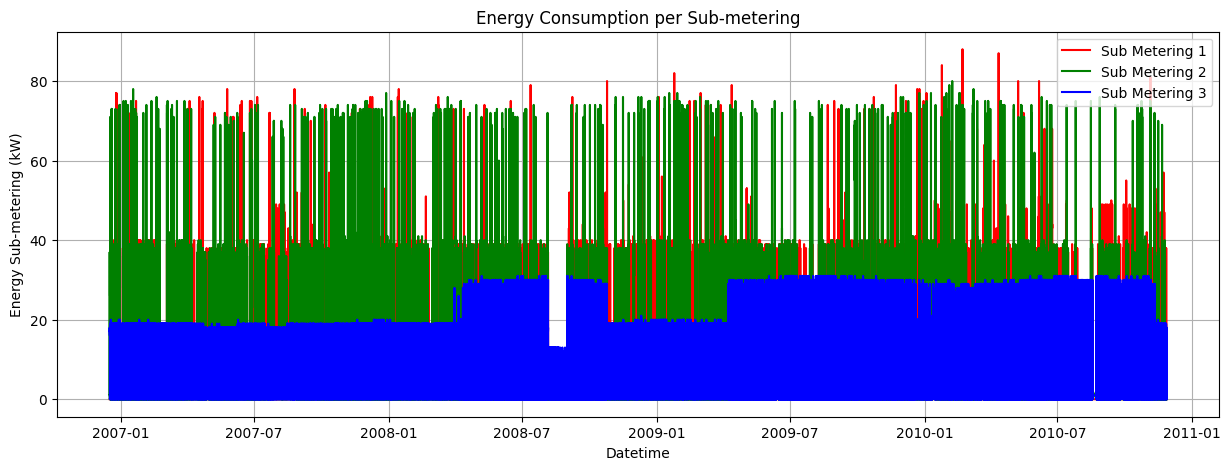

In [53]:
# Step 3: Visualizations
plt.figure(figsize=(15, 5))
plt.plot(data['datetime'], data['Global_active_power'], label='Global Active Power', color='blue')
plt.title('Global Active Power Over Time')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(data['datetime'], data['Sub_metering_1'], label='Sub Metering 1', color='red')
plt.plot(data['datetime'], data['Sub_metering_2'], label='Sub Metering 2', color='green')
plt.plot(data['datetime'], data['Sub_metering_3'], label='Sub Metering 3', color='blue')
plt.title('Energy Consumption per Sub-metering')
plt.xlabel('Datetime')
plt.ylabel('Energy Sub-metering (kW)')
plt.legend()
plt.grid()
plt.show()

In [54]:
# Select target variable and features
features = ['hour', 'day', 'month', 'Global_active_power', 'Global_reactive_power', 'Voltage']
X = data[features]
y = data['Global_active_power']

# Scale data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))


In [55]:
# Create sliding window sequences
def create_sequences(data, target, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = target[i + seq_length]
        sequences.append(seq)
        targets.append(label)
    return np.array(sequences), np.array(targets)


In [56]:
seq_length = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_train_tensor = torch.tensor(y_train).float()
y_test_tensor = torch.tensor(y_test).float()


In [57]:
# Define LSTM model
class PowerConsumptionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PowerConsumptionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

In [58]:
# Initialize model
input_size = X_train.shape[2]
hidden_size = 50
output_size = 1
model = PowerConsumptionLSTM(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {loss.item()}")


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 180518072320 bytes.

In [59]:
from torch.utils.data import DataLoader, TensorDataset

# Reduce sequence length if needed
seq_length = 12  # Reduced from 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_length)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Use DataLoader for memory-efficient batching
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop with DataLoader
n_epochs = 50
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {epoch_loss / len(train_loader)}")


Epoch 10/50, Loss: 0.00047470678354473905
Epoch 20/50, Loss: 0.00045341459736156193
Epoch 30/50, Loss: 0.0004429149345656887
Epoch 40/50, Loss: 0.0004352841528445674
Epoch 50/50, Loss: 0.00042982785214953494


In [65]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Move model and data to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
X_test_tensor = X_test_tensor.to(device)

# Create a DataLoader for batching
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

# Evaluate model in batches
predictions = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch[0]  # Extract batch
        batch_preds = model(batch).cpu().numpy()  # Move predictions back to CPU
        predictions.append(batch_preds)

# Combine all predictions
predictions = np.concatenate(predictions, axis=0)

# Inverse transform predictions
predictions = scaler.inverse_transform(predictions)



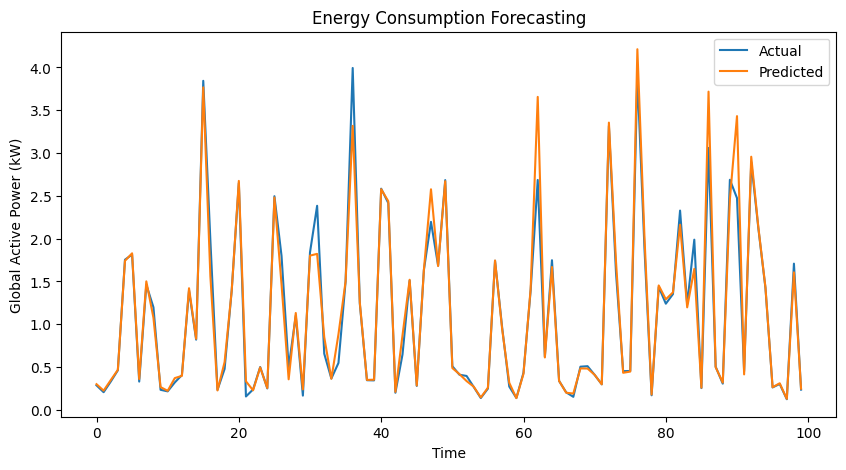

In [69]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the appropriate device

# Evaluate model
model.eval()
batch_size = 100
num_batches = len(X_test_tensor) // batch_size

actual_values = []
predicted_values = []

with torch.no_grad():
    for i in range(num_batches):
        # Move input batch to the same device as the model
        X_batch = X_test_tensor[i * batch_size:(i + 1) * batch_size].to(device)
        y_batch = y_test_tensor[i * batch_size:(i + 1) * batch_size].to(device)

        # Predict and scale back
        predictions_batch = model(X_batch).cpu().numpy()  # Move output to CPU for NumPy conversion
        predictions_batch = scaler.inverse_transform(predictions_batch)
        actual_batch = scaler.inverse_transform(y_batch.cpu().numpy())  # Move target to CPU for scaling back

        actual_values.extend(actual_batch)
        predicted_values.extend(predictions_batch)

# Convert lists back to numpy arrays
actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)

# Plot results (Subset to the first 100 samples for visualization)
plt.figure(figsize=(10, 5))
plt.plot(actual_values[:100], label="Actual")
plt.plot(predicted_values[:100], label="Predicted")
plt.legend()
plt.title("Energy Consumption Forecasting")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.show()


In [71]:
predicted_data = pd.DataFrame({"Actual": y_test_tensor.flatten(), "Predicted": predictions.flatten()})
predicted_data.to_csv("energy_forecast.csv", index=False)
print("Predictions saved to energy_forecast.csv")

Predictions saved to energy_forecast.csv


In [73]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f"RMSE: {rmse}")


#

RMSE: 0.2348715364933014
